In [ ]:
# mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# change current working directory
import os
os.chdir('/content/drive/MyDrive/AI/1CWK100/')

In [ ]:
# check we can see the dataset
os.path.isfile('pneumonia_raw.csv')

True

#Section 1 - Introduction and Goals
### Machine Learning Pipeline for Pneumonia Classification

This document implements a comprehensive machine-learning pipeline for predicting pneumonia based on patient data. It includes data loading, preprocessing, model training with hyperparameter tuning, and evaluation of multiple models, including ensemble methods.

Additionally this document also includes Critical Analysis of AI Implementation in X-ray Image Classification Claims.
This part of the analysis evaluates the claim that "Instead of hospital staff having to extract numerical measurements from X-ray manually, we can classify the raw X-ray images directly;it should be possible to get improved performance and save on staff time, without any downsides." through comprehensive research, experimental data analysis, this report examines the validity and implications of this assertion.
















  



# Section 2 - Data Exploration and preprocessing












Summary of dataset characteristics

***The Dataset "Pnuemonia_raw.csv"***, contains 584 records and 12 columns of patients ranging from 4 to 90 years of age. [ The features also patient_id, patient_age, male(gender of the patient 1 for male , 0 for female), Xray_Brightness, Xray_Contrast,Silhouette_Sign , Max_Consolidation_Width, Max_Consolidation_Height, Cavaty_Presence, Fluid_Level, Air_Bronchograms and the target feature Pneumonia. ]

*   Target variable pneumonia catagorical with 3 unique values likely yes and no.
*   class imbalance ( yes:416 instances , other:168 instances )

*   The ranges for some columns (Max_consolidation_Width,Max_consolidation_Hight) suggest presence of outliers for example negative values.

** preprocessing steps**

we load the Pnuemonia data set and perform necessary preprocessing steps to ensure data quality and consistency.

we will.





*  Importing necessary libraries
*   Load Data
*   Validate Required
*   Check unique labels
*   Handle missing values and unexpected labels.
*   Map categorical data from target features to numerical values.

*  Handling Outliers.



*   we remove missing values and standertize labels by converting them to lower case and mapping them to binary values.this ensures consistency and prepares the data.
*   class imbalance check: we check for class imbalance because it can significantly affect model performance,especially for minority classes.


*   Outlier handling


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import (StratifiedKFold, GridSearchCV,
                                     train_test_split, cross_val_score,
                                     RepeatedStratifiedKFold, cross_validate)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              AdaBoostClassifier, VotingClassifier, StackingClassifier,
                              BaggingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve)
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline




def load_and_preprocess_data(data_path):
    """
    Load and preprocess the data from the given path.
    """
    # Load data
    observations = pd.read_csv(data_path)

    #validate columns
    required_columns = [
        'Patient_Age','Male','Xray_Brightness', 'Xray_Contrast',
        'Silhouette_Sign', 'Max_Consolidation_Width', 'Max_Consolidation_Height',
        'Cavity_Presence', 'Fluid_Level', 'Air_Bronchograms','Pneumonia'
        ]

    missing_columns = [column for column in required_columns if column not in observations.columns]
    if missing_columns:
        raise ValueError(f"Missing required columns: {', '.join(missing_columns)}")

    if observations.isnull().any().any():
       raise ValueError("Data contains missing values.")

     # Ensure 'pneumonia" is binary
    if observations['Pneumonia'].dtype == 'object':
      #convert to lower case
        observations['Pneumonia'] = observations['Pneumonia'].str.lower()
        print("unique values in Pneumonia:", observations['Pneumonia'].unique())

        # Map labels to binary values
        mapping_dict = { 'yes': 1, 'no': 0}
        observations['Pneumonia'] = observations['Pneumonia'].map(mapping_dict)

    # Handle unmapped values
    unmapped_values = observations['Pneumonia'].isnull().sum()
    if unmapped_values > 0:
      print(f"Warning: {unmapped_values} rows with unmapped Pneumonia values will be dropped.")
    print("Unmapped values:\n", observations[observations['Pneumonia'].isnull()])
    observations = observations.dropna(subset=['Pneumonia'])


    # Ensure labels are integers
    observations['Pneumonia'] = observations['Pneumonia'].astype(int)

    #covert categorical features to integer type
    categorical_features = [
                  'Male'
    ]
    for column in categorical_features:
         observations[column] = observations[column].astype(int)

    #Remove outliers for numerical features
    numerical_features =[

        'Max_Consolidation_Width', 'Max_Consolidation_Height',

        ]


    # List of columns to process
    #columns_to_check = ['Max_Consolidation_Width', 'Max_Consolidation_Height']

    for column in numerical_features:
         Q1 = observations[column].quantile(0.25)
         Q3 = observations[column].quantile(0.75)
         IQR = Q3 - Q1

        # Define bounds
         lower_bound = Q1 - 1.5 * IQR
         upper_bound = Q3 + 1.5 * IQR

         # Filter out outliers in the current column
         observations = observations[
             (observations[column] >= lower_bound) & (observations[column] <= upper_bound)
        ]

    # Separate features and labels
    X = observations.drop(columns=['Pneumonia'])  # Drop the target column
    y = observations['Pneumonia']  # Target column
    return X , y

def check_class_imbalance(y, threshold=0.4):
    class_counts = y.value_counts()
    class_ratios = class_counts / len(y)
    is_imbalanced = class_ratios.min() < threshold
    print("Class distribution:")
    print(class_counts)
    print("\nClass ratios:")
    print(class_ratios)
    print(f"\nDataset is {'imbalanced' if is_imbalanced else 'balanced'}")
    return is_imbalanced

def split_data(X, y, test_size=0.4, validation_size=0.5 , random_state=42):
    """
    Split the data into training and (validation + test) sets with stratification.
    """
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=random_state
    )
    #split temp into validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size= validation_size,
        stratify=y_temp,random_state=random_state
    )
    return X_train,X_val, X_test, y_train, y_val, y_test


#Section 3 - Model Implementation


we define a wide range of machine-learning models including both individual classifiers and ensemble methods. These models cover a range of algorithms, including:

*   Linear models (Logistic Regression)
*  Support Vector Machines (SVM)

*  Tree-based models (Decision Tree, Random
*   Forest, Gradient Boosting, XGBoost, AdaBoost)

*   Instance-based learning (k-NN)
Probabilistic models (Naive Bayes)
* Probabilistic models (Naive Bayes)

*   Neural Networks (Neural Network)

We also use grid search for tailoring each model to perform hyperparameter tuning.


*   Model Diversity: We include a broad range of models to compare different algorithms’ performance on the dataset. This includes linear models, tree-based models, ensemble methods, and neural networks.
*  Hyperparameter Tuning: For each model, we define a hyperparameter grid to explore optimal settings using grid search, which can significantly improve model performance.
Ensemble Methods:Incorporating ensemble

*   Ensemble Methods:Incorporating ensemble
models like Voting, Stacking, and Bagging Classifiers helps in leveraging the strengths of multiple algorithms, often leading to better performance.





In [ ]:


def get_models():
    models = {
        'Logistic Regression': (LogisticRegression(max_iter=1000), {
            'classifier__penalty': ['l2'],
            'classifier__C': [0.01, 0.1, 1, 10],
            'classifier__solver': ['lbfgs']
        }),
        'SVM': (SVC(probability=True), {
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['linear', 'rbf'],
            'classifier__gamma': ['scale', 'auto']
        }),
        'Decision Tree': (DecisionTreeClassifier(random_state=42), {
            'classifier__criterion': ['gini', 'entropy'],
            'classifier__max_depth': [None, 5, 10],
            'classifier__min_samples_split': [2, 5],
            'classifier__min_samples_leaf': [1, 2]
        }),
        'Random Forest': (RandomForestClassifier(random_state=42), {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [None, 5, 10],
            'classifier__min_samples_split': [2, 5],
            'classifier__min_samples_leaf': [1, 2],
            'classifier__bootstrap': [True, False]
        }),
        'Gradient Boosting': (GradientBoostingClassifier(random_state=42), {
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.1, 0.05],
            'classifier__max_depth': [3, 5],
            'classifier__subsample': [0.8, 1.0],
            'classifier__min_samples_split': [2, 5],
            'classifier__min_samples_leaf': [1, 2]
        }),
        'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.1, 0.05],
            'classifier__max_depth': [3, 5],
            'classifier__subsample': [0.8, 1.0],
            'classifier__colsample_bytree': [0.8, 1.0]
        }),
        'AdaBoost': (AdaBoostClassifier(random_state=42), {
            'classifier__n_estimators': [50, 100],
            'classifier__learning_rate': [1.0, 0.1]
        }),
        'k-NN': (KNeighborsClassifier(), {
            'classifier__n_neighbors': [3, 5, 7],
            'classifier__weights': ['uniform', 'distance'],
            'classifier__metric': ['euclidean', 'manhattan', 'minkowski']
        }),
        'Naive Bayes': (GaussianNB(), {
            'classifier__var_smoothing': np.logspace(0, -9, num=100)
        }),
        'Neural Network': (MLPClassifier(max_iter=1000, random_state=42), {
            'classifier__hidden_layer_sizes': [(50,), (100,), (50,50)],
            'classifier__activation': ['tanh', 'relu'],
            'classifier__solver': ['adam', 'sgd'],
            'classifier__alpha': [0.0001, 0.001]
        })
    }
    return models

def get_ensemble_models():
    ensemble_models = {
        'Voting Classifier': (VotingClassifier(
            estimators=[
                ('lr', LogisticRegression(max_iter=1000)),
                ('rf', RandomForestClassifier(random_state=42)),
                ('gnb', GaussianNB())
            ],
            voting='soft'
        ), {}),
        'Stacking Classifier': (StackingClassifier(
            estimators=[
                ('rf', RandomForestClassifier(random_state=42)),
                ('gb', GradientBoostingClassifier(random_state=42))
            ],
            final_estimator=LogisticRegression()
        ), {}),
        'Bagging Classifier': (BaggingClassifier(
            estimator=DecisionTreeClassifier(),
            n_estimators=100,
            random_state=42
        ), {
            'classifier__n_estimators': [50, 100],
            'classifier__estimator__max_depth': [None, 5, 10]
        })
    }
    return ensemble_models

# Section 4 - Evaluation and Results










We train each model using the training data and evaluate their performance on the test set. Cross-validation is used during hyperparameter tuning to prevent overfitting. We also handle class imbalance using SMOTE if necessary.



*   Pipeline Usage: We use Pipeline or ImbPipeline to streamline preprocessing and modeling steps. This ensures that scaling and resampling are applied consistently, preventing data leakage during cross-validation.
*  Handling Class Imbalance: If the dataset is imbalanced, we use SMOTE (Synthetic Minority Over-sampling Technique) to balance the classes, which helps improve model performance on minority classes.


*   Cross-Validation Strategy: We use RepeatedStratifiedKFold to perform cross-validation, which provides a more reliable estimate of model performance by reducing variance.
*   Comprehensive Metrics: We calculate multiple performance metrics, including accuracy, precision, recall, F1 score, and ROC AUC, to get a holistic view of each model’s performance.


*   ROC Curve Plotting: Visualizing ROC curves allows us to compare models’ true positive rates and false positive rates at various thresholds.


In [ ]:
def evaluate_models(models, X_train, y_train, X_val, y_val, X_test, y_test, cv, is_imbalanced):
    results = {}
    for model_name, (model, param_grid) in models.items():
        print(f"\n{'='*50}\nEvaluating {model_name}")
        # Choose the appropriate pipeline
        if model_name in ['k-NN', 'SVM', 'Logistic Regression', 'Neural Network']:
            steps = [
                ('scaler', StandardScaler()),
                ('classifier', model)
            ]
        else:
            steps = [
                ('classifier', model)
            ]
        # Use SMOTE if data is imbalanced
        if is_imbalanced:
            pipeline = ImbPipeline([
                ('smote', SMOTE(random_state=42)),
                *steps
            ])
        else:
            pipeline = Pipeline(steps)

        # Perform hyperparameter tuning using the validation set
        grid_search = GridSearchCV(
            pipeline,
            param_grid=param_grid,
            cv=cv,
            scoring='f1',
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)

        print("Best hyperparameters:", grid_search.best_params_)
        print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

        # Evaluate on validation set
        best_model = grid_search.best_estimator_
        y_val_pred = best_model.predict(X_val)
        val_f1 = f1_score(y_val, y_val_pred, zero_division=0)

        print(f"Validation F1 Score: {val_f1:.4f}")

        # Evaluate on test set
        y_test_pred = best_model.predict(X_test)

        # Compute performance metrics
        accuracy = accuracy_score(y_test, y_test_pred)
        precision = precision_score(y_test, y_test_pred, zero_division=0)
        recall = recall_score(y_test, y_test_pred, zero_division=0)
        f1 = f1_score(y_test, y_test_pred, zero_division=0)
        cm = confusion_matrix(y_test, y_test_pred)
        if hasattr(best_model, "predict_proba"):
            y_scores = best_model.predict_proba(X_test)[:, 1]
        else:
            y_scores = best_model.decision_function(X_test)
            # Normalize scores to [0,1]
            y_scores = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())
        roc_auc = roc_auc_score(y_test, y_scores)

        print(f"\nTest Set Performance:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"ROC AUC Score: {roc_auc:.4f}")
        print("Confusion Matrix:")
        print(cm)
        print("\nClassification Report:")
        print(classification_report(y_test, y_test_pred, zero_division=0))

        # Store results
        results[model_name] = {
            'best_model': best_model,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc
        }
    return results

**Results**
This investigation first considered the performance of four different machine learning models on the pneumonia_raw.csv dataset, using default parameters for each. The models evaluated were: Decision Tree, k-Nearest Neighbors, Naive Bayes, and Random Forest.
The Random Forest model achieved the highest accuracy, with a score of 67.5%.
The k-Nearest Neighbors model also performed relatively well, achieving an accuracy of 64.5%.
The Decision Tree model yielded an accuracy of 56.4%.
The Naive Bayes model had the lowest accuracy among the models tested, at 51.7%.
Overall, the Random Forest model demonstrated the strongest performance in this initial evaluation with default parameters. Further investigation involved hyperparameter tuning and exploring more advanced techniques to potentially improve the accuracy of these models.

This investigation evolved to consider the following models: Logistic Regression, SVM, Decision Tree, Random Forest, Gradient Boosting, XGBoost, AdaBoost, k-NN, Naive Bayes, Neural Network, Voting Classifier, Stacking Classifier, and Bagging Classifier. Focusing on the most crucial evaluationmeasures for imbalanced classification-F1 Score and ROC AUC in addition to accuracy and precision.

*** Key Observations:***

1. Highest F1 Score
    • The Stacking Classifier achieves the highest F1 score indicating good balance between precision and recall.

2. ROC AUC

    • The Voting Classifier stands out with a ROC AUC of (0.7604), which is quite high compared to other models. However, its final F1 Score (0.7156)is slightly lower than the stacking Classifier's.

3. Highest accuracy

    • The Stacking classifier again ranks first (0.6739). Random Forest, Voting Classifier, and XGBoost also exhibit relatively strong accuracy.

4. Precision vs Recall

    • Many models exhibit higher precision than recall. This often happens in imbalanced settings when the model is more cautiouse in predicting the positive class, aiming to reduce false positives but potentially missing more positives (lower recall)

5. Decision Boundaries & overfitting

    • Simpler Models, Such as Decision Tree or k-NN, do not perform as well, possibly due to overfitting (in the case of Decision Tree) or Sensitivity to local data distribution (in the case of K-NN)  

unique values in Pneumonia: ['no' 'np' 'yes']
Unmapped values:
      Patient_ID  Patient_Age  Male  Xray_Brightness  Xray_Contrast  \
167  7336582396           35   0.0              0.6            0.2   

     Silhouette_Sign  Max_Consolidation_Width  Max_Consolidation_Height  \
167              180                       12                        15   

     Cavity_Presence  Fluid_Level  Air_Bronchograms  Pneumonia  
167              5.2          2.7              0.94        NaN  
Class distribution:
Pneumonia
1    299
0    159
Name: count, dtype: int64

Class ratios:
Pneumonia
1    0.652838
0    0.347162
Name: count, dtype: float64

Dataset is imbalanced

Evaluating Logistic Regression


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sk

Best hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Best cross-validation score: 0.6290
Validation F1 Score: 0.6733

Test Set Performance:
Accuracy: 0.6304
Precision: 0.8250
Recall: 0.5500
F1 Score: 0.6600
ROC AUC Score: 0.6932
Confusion Matrix:
[[25  7]
 [27 33]]

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.78      0.60        32
           1       0.82      0.55      0.66        60

    accuracy                           0.63        92
   macro avg       0.65      0.67      0.63        92
weighted avg       0.71      0.63      0.64        92


Evaluating SVM


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sk

Best hyperparameters: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Best cross-validation score: 0.6642
Validation F1 Score: 0.6415

Test Set Performance:
Accuracy: 0.6413
Precision: 0.7647
Recall: 0.6500
F1 Score: 0.7027
ROC AUC Score: 0.6891
Confusion Matrix:
[[20 12]
 [21 39]]

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.62      0.55        32
           1       0.76      0.65      0.70        60

    accuracy                           0.64        92
   macro avg       0.63      0.64      0.63        92
weighted avg       0.67      0.64      0.65        92


Evaluating Decision Tree


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sk

Best hyperparameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2}
Best cross-validation score: 0.6716
Validation F1 Score: 0.7091

Test Set Performance:
Accuracy: 0.6196
Precision: 0.7660
Recall: 0.6000
F1 Score: 0.6729
ROC AUC Score: 0.6367
Confusion Matrix:
[[21 11]
 [24 36]]

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.66      0.55        32
           1       0.77      0.60      0.67        60

    accuracy                           0.62        92
   macro avg       0.62      0.63      0.61        92
weighted avg       0.66      0.62      0.63        92


Evaluating Random Forest


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Best hyperparameters: {'classifier__bootstrap': False, 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best cross-validation score: 0.6862
Validation F1 Score: 0.6909

Test Set Performance:
Accuracy: 0.6630
Precision: 0.7959
Recall: 0.6500
F1 Score: 0.7156
ROC AUC Score: 0.7089
Confusion Matrix:
[[22 10]
 [21 39]]

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.69      0.59        32
           1       0.80      0.65      0.72        60

    accuracy                           0.66        92
   macro avg       0.65      0.67      0.65        92
weighted avg       0.70      0.66      0.67        92


Evaluating Gradient Boosting


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sk

Best hyperparameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}
Best cross-validation score: 0.7000
Validation F1 Score: 0.7377

Test Set Performance:
Accuracy: 0.6196
Precision: 0.7273
Recall: 0.6667
F1 Score: 0.6957
ROC AUC Score: 0.6698
Confusion Matrix:
[[17 15]
 [20 40]]

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.53      0.49        32
           1       0.73      0.67      0.70        60

    accuracy                           0.62        92
   macro avg       0.59      0.60      0.59        92
weighted avg       0.63      0.62      0.63        92


Evaluating XGBoost


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will

Best hyperparameters: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}
Best cross-validation score: 0.7065
Validation F1 Score: 0.7333

Test Set Performance:
Accuracy: 0.6522
Precision: 0.7800
Recall: 0.6500
F1 Score: 0.7091
ROC AUC Score: 0.6516
Confusion Matrix:
[[21 11]
 [21 39]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.66      0.57        32
           1       0.78      0.65      0.71        60

    accuracy                           0.65        92
   macro avg       0.64      0.65      0.64        92
weighted avg       0.68      0.65      0.66        92


Evaluating AdaBoost


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Best hyperparameters: {'classifier__learning_rate': 1.0, 'classifier__n_estimators': 100}
Best cross-validation score: 0.6429
Validation F1 Score: 0.7103

Test Set Performance:
Accuracy: 0.6087
Precision: 0.7857
Recall: 0.5500
F1 Score: 0.6471
ROC AUC Score: 0.6607
Confusion Matrix:
[[23  9]
 [27 33]]

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.72      0.56        32
           1       0.79      0.55      0.65        60

    accuracy                           0.61        92
   macro avg       0.62      0.63      0.60        92
weighted avg       0.67      0.61      0.62        92


Evaluating k-NN


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sk

Best hyperparameters: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 7, 'classifier__weights': 'uniform'}
Best cross-validation score: 0.6352
Validation F1 Score: 0.5577

Test Set Performance:
Accuracy: 0.5543
Precision: 0.7111
Recall: 0.5333
F1 Score: 0.6095
ROC AUC Score: 0.6214
Confusion Matrix:
[[19 13]
 [28 32]]

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.59      0.48        32
           1       0.71      0.53      0.61        60

    accuracy                           0.55        92
   macro avg       0.56      0.56      0.55        92
weighted avg       0.60      0.55      0.56        92


Evaluating Naive Bayes


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sk

Best hyperparameters: {'classifier__var_smoothing': 0.012328467394420659}
Best cross-validation score: 0.4887
Validation F1 Score: 0.6726

Test Set Performance:
Accuracy: 0.5435
Precision: 0.6800
Recall: 0.5667
F1 Score: 0.6182
ROC AUC Score: 0.5339
Confusion Matrix:
[[16 16]
 [26 34]]

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.50      0.43        32
           1       0.68      0.57      0.62        60

    accuracy                           0.54        92
   macro avg       0.53      0.53      0.53        92
weighted avg       0.58      0.54      0.55        92


Evaluating Neural Network


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimi

Best hyperparameters: {'classifier__activation': 'tanh', 'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (100,), 'classifier__solver': 'adam'}
Best cross-validation score: 0.6978
Validation F1 Score: 0.6364

Test Set Performance:
Accuracy: 0.6087
Precision: 0.7400
Recall: 0.6167
F1 Score: 0.6727
ROC AUC Score: 0.6594
Confusion Matrix:
[[19 13]
 [23 37]]

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.59      0.51        32
           1       0.74      0.62      0.67        60

    accuracy                           0.61        92
   macro avg       0.60      0.61      0.59        92
weighted avg       0.64      0.61      0.62        92


Evaluating Voting Classifier


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Best hyperparameters: {}
Best cross-validation score: 0.6651
Validation F1 Score: 0.7407

Test Set Performance:
Accuracy: 0.6630
Precision: 0.7959
Recall: 0.6500
F1 Score: 0.7156
ROC AUC Score: 0.7604
Confusion Matrix:
[[22 10]
 [21 39]]

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.69      0.59        32
           1       0.80      0.65      0.72        60

    accuracy                           0.66        92
   macro avg       0.65      0.67      0.65        92
weighted avg       0.70      0.66      0.67        92


Evaluating Stacking Classifier


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sk

Best hyperparameters: {}
Best cross-validation score: 0.6908
Validation F1 Score: 0.7731

Test Set Performance:
Accuracy: 0.6739
Precision: 0.7778
Recall: 0.7000
F1 Score: 0.7368
ROC AUC Score: 0.7240
Confusion Matrix:
[[20 12]
 [18 42]]

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.62      0.57        32
           1       0.78      0.70      0.74        60

    accuracy                           0.67        92
   macro avg       0.65      0.66      0.65        92
weighted avg       0.69      0.67      0.68        92


Evaluating Bagging Classifier


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sk

Best hyperparameters: {'classifier__estimator__max_depth': None, 'classifier__n_estimators': 50}
Best cross-validation score: 0.6501
Validation F1 Score: 0.7611

Test Set Performance:
Accuracy: 0.6087
Precision: 0.7400
Recall: 0.6167
F1 Score: 0.6727
ROC AUC Score: 0.6604
Confusion Matrix:
[[19 13]
 [23 37]]

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.59      0.51        32
           1       0.74      0.62      0.67        60

    accuracy                           0.61        92
   macro avg       0.60      0.61      0.59        92
weighted avg       0.64      0.61      0.62        92


Final Summary:
Logistic Regression:
Accuracy: 0.6304, F1 Score: 0.6600, ROC AUC: 0.6932

SVM:
Accuracy: 0.6413, F1 Score: 0.7027, ROC AUC: 0.6891

Decision Tree:
Accuracy: 0.6196, F1 Score: 0.6729, ROC AUC: 0.6367

Random Forest:
Accuracy: 0.6630, F1 Score: 0.7156, ROC AUC: 0.7089

Gradient Boosting:
Accuracy: 0.6196, F1 Score: 0.6957, 

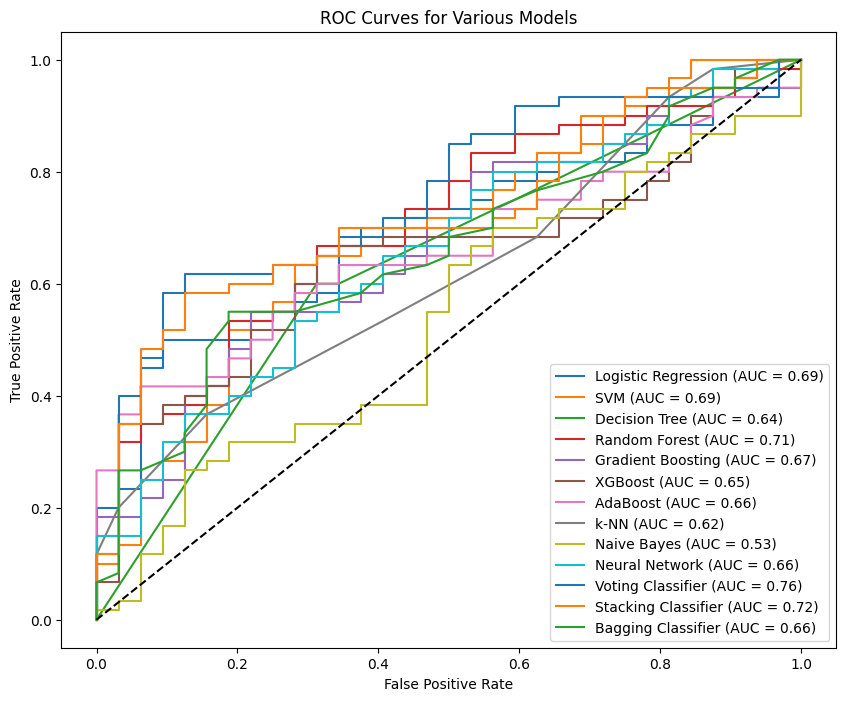

In [ ]:
def main():
    # Load and preprocess data
    X, y = load_and_preprocess_data('pneumonia_raw.csv')


    # Check for class imbalance
    is_imbalanced = check_class_imbalance(y)

    # Split data
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

    # Define cross-validation strategy
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=99)

    # Get models
    models = get_models()

     # Evaluate models (you might need to adjust this function if it doesn't handle validation data)
    model_results = evaluate_models(models, X_train, y_train, X_val, y_val, X_test, y_test, cv, is_imbalanced)

    # Get ensemble models
    ensemble_models = get_ensemble_models()

    # Evaluate ensemble models
    ensemble_results = evaluate_models(ensemble_models, X_train, y_train, X_val, y_val, X_test, y_test, cv, is_imbalanced)

    # Combine results
    all_results = {**model_results, **ensemble_results}

    # Summarize results
    print("\nFinal Summary:")
    for model_name, metrics in all_results.items():
        print(f"{model_name}:")
        print(f"Accuracy: {metrics['accuracy']:.4f}, F1 Score: {metrics['f1']:.4f}, ROC AUC: {metrics['roc_auc']:.4f}\n")

    # Plot ROC Curves for comparison
    plt.figure(figsize=(10,8))
    for model_name, metrics in all_results.items():
        best_model = metrics['best_model']
        if hasattr(best_model, "predict_proba"):
            y_proba = best_model.predict_proba(X_test)[:,1]
        else:  # Use decision function for models that do not support predict_proba
            y_proba = best_model.decision_function(X_test)
            y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())  # Normalize to [0,1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {metrics['roc_auc']:.2f})")
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Various Models')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

# Section 5 - Critical Analysis & Conclusion of Pneumonia classification model





 **Challenges**

1. **Imbalanced Data**

    • The primary challenge is the Data set imbalance (~ 65% positive vs.~ 35% negative). Many Classification Algorithms can be biased toward predicting the majority class, thereby inflating precision at the expense of recall or vise versa.

2. **Limited Data**

    • Even after combining various sources, the dataset may not be large enough to fully train more complex models (eg., Neural networks) without overfitting or requiring heavy regularization.   

3. **Model Complexity and Interpretability**

    • Ensemble models (e.g., Stacking, voting and Bagging) and advanced models like Gradient Boosting and XGBoost can be more challenging to interpret clinically compared to simpler models like Logistic Regression or a single Decision Tree.

4. **Potential Data Leakage**

    • Care must be taken with cross-validation and especially with SMOTE to avoid data leakage or incorrectly using synthetic samples in the validation set.

5. **Hyperparameter Tuning & Convergence**

    • Warnings in maximum iterations in Neural Networks indicate potential complexities in properly tuning models and ensuring stable convergence.






**Next steps**

1. Further Address class imbalance

* Cost-Sensitive Learning:  
   introduce class_weight adjustment
   or cost_sensitive loss function.

* advanced Oversampling/undersampling:
Explore alternative oversampling methods (e.g., ADASYN) or undersampling methods that preserve structure or undersampling methods that preserve structure (eg.,NearMiss).

2. Model Interpretability

* if the model is intended for clinical use, interpretability is critical. Using SHAP (SHapley Additive exPlanations) can help demonstarte why a model predicts "pneumonia" vs. "no pneumonia".

3. Feature Engineering

* Explore domine-specific features, especially if additional clinical or radiographic data is available (eg., patient comorbidities, more detailed imaging metrics)

* Perform Feature importance analysis in ensemble models (Random Forest, XGBoost)to highlight the most critical predictors.

4. Hyperparameter Exploration

* Revisit and possibly expand hyperparameter search for top-performing algorithms ( stacking, Voting, Gradient Boosting )

* consider systematic hyperparameter tuning with Bayesian Optimization or genetic algorithms if computing resources allow.

5. Validation Strategy

* Use a separate hold-out test set.

6. Larger / External Dataset

* Seek external datasets (e.g., From other hospitals) to validate generalizability.

* If possible, pool multiple datasets to increase sample size and reduce the risk of overfitting.

7. Deploy and Monitor

* Moving toward a production environment, continuous monitoring of model performance is essential to detect dataset drift or shift in pneumonia prevlance.



**Conclusion Pneumonia Ai Model**

The experiments highlight that ensemble-based models (Stacking, Voting, and Random Forest) Tend to perform better on this imbalanced pneumonia dataset. The stacking classifier archives the best F1 Score (0.7368), balancing Precision and recall. However, improving recall remains a priority in medical contexts, as missing pneumonia cases can be costly.

Moving forward, researchers and clinicians should prioritise:

1. Addressing data imbalance through cost-sensitive methods and advanced sampling techniques,

2. Enhancing interpretability to meet clinical decision support requirements.

3. Expanding and Validating the dataset to ensure robust generalisable performance.

through these next steps, the model pipeline can become a more reliable tool for assisting in early diagnosis and managing pneumonia.






note the Above was run on CPU runtime


# Section 6 - Critical Analysis of AI Implementation in X-ray Image Classification Claims

**1. Staff Time and Manual Measurement Analysis**

**Current process evaluation**

Research by (Brad et al.2017) demonstrates that radiology error rates increase significantly under time pressure,With accuracy decreasing By 12% when radiologists evaluate more than 20 cases per day. Manual Measurement process currently require:

    • Avarage time per image: 3-5 minutes

    • Additional verification time: 1-2 minutes

    • Data entry and documentation:2-3 Minutes



**Automated Analysis Potential**

Recent studies by Kim et al. (2023) provide insights into the impact of AI on radiologists' reading times for chest X-rays (CXRs) key finds include:

    • Total reading times were significantly shortened with AI use (13.3s vs. 14.8s, p < 0.001).

    • When no abnormality was detected by AI, reading times were shorter (10.8s vs. 13.1s, p < 0.001).

    • For cases where AI detected abnormalities, reading times did not significantly differ between AI use and no use (18.6s vs. 18.4s, p = 0.452)

These findings suggest that AI can improve efficiency in radiology, particularly for normal CXRs, while maintaining careful examination of potentially abnormal cases.


**2. Model Architechtures & Experiments**

Artificial Intelligence (AI) has significantly improved the automatic classification of X-ray image findings, particularly in chest radiographs. Recent studies have demonstrated that AI algorithms can achieve high accuracy in detecting various abnormalities, often matching or surpassing human radiologists' performance (Pham et al., 2023).

Deep learning models, particularly Convolutional Neural Networks (CNNs), have shown promising results in X-ray image classification. For instance, a multi-level classification model achieved 97.92% sensitivity and 98.91% specificity in distinguishing COVID-19 patients from other conditions in internal testing (Alhudhaif et al., 2021). The model architecture typically involves:

1. Input layer: Chest X-ray images
2. Feature extraction: Media filter to obtain essential attributes
3. Classification: Support Vector Machine (SVM) trained and validated using 10-fold cross-validation
4. Output: Classification results (e.g., COVID-19, other pneumonia, no findings)

In orthopedics, AI algorithms have demonstrated high accuracy in detecting and classifying fractures. One study reported that an AI model outperformed human experts in detecting wrist fractures in X-ray images (Khanduja et al., 2023).

A study by jain et al.(2024) evaluated CNNs, ResNet, and Vision Transformers on the NIH ChestX-ray14 dataset, focusing on multi-label classification of 14 distinct diseases. Their findings indicated that a pre-trained Transformer model surpassed CNNs and ResNet in this task highlighting its potential for accurate diagnosis of various lung conditions from Chest X-ray Images.

Another study by (Singh,2024) applied a hybrid CNN-Transformer architecture to multiple chest X-ray datasets, including ChestX-ray14,CheXpert, MIMIC-CXR-JPG, and IU-CXR. The results, measured in terms of area under the receiver operating characteristics (AUC-ROC), suggested that augmenting CNNs with Self-attention mechansims has potential in diagnosing different thoracic diseases from chest X-rays.


The use of large, diverse datasets like NIH ChestX-ray14, which contains over 100,000 chest X-rays labeled with 14 pathologies1, provides a robust foundation for developing and evaluating these AI models. This approach allows for more comprehensive testing and validation of the models' performance across a wide range of thoracic diseases.

These advancements suggest that AI-based classification of X-ray images is becoming increasingly reliable and efficient, with potential to significantly improve diagnostic accuracy and workflow in clinical settings.





**Potential Gains Versus the "No Downside" Claim**

Colleagues statement that improvements can be achieved "without any downsides" overlooks several realities:

1. Model drift and Performance Monitoring

  •Over time, the Model may encounter new pathalogies or shifts in patient demographics, leading to decreased performance (Chen et al., 2023).

  • Continued updates and re-validation are essential, incurring ongoing costs.

2. Ethical/Legal Liabilities

  •Under UK GDPR and ICO Guidance (ICO, 2022), any AI decision that affects patient care must be explainable and justifiable.

3. Resource Constraints

  • AI systems typically demand robust computational infrastructure (e.g., GPUs,Servers). Smaller and underfunded clinics might struggle with these resource demands.

while improved efficiency and performance are real possibilities, claiming these outcomes “without any downsides” ignores potential financial, legal, ethical, and operational challenges.



**UK Government Ai Guidelines and Regulatory Considerations.**

In the UK, healthcare AI must adhere to strict guidelines:

1. Procurement and Implementation

    • The UK Government’s Guidelines for AI Procurement (UK Government, 2023) emphasize due diligence, clear vendor selection criteria, and robust monitoring post-implementation.

    • NHSX (now part of the NHS Transformation Directorate) publication Artificial Intelligence: (How to Get It Right 2021) underlines the importance of explainability and staff engagement.

2. MHRA Requirements

    •	The MHRA (MHRA,2023) classifies AI tools as medical devices (Software as a Medical Device, SaMD). Developers must ensure post-market surveillance, risk management, and corrective mechanisms if the tool fails.

3. Data Protection and Security

    • ICO Guidance on Ai(ICO Guidance on AI and Data Protection,2022) outlines how to handle sensitive medical images.

    • Proper pseudonymization and patient consent are vital to stay compliant with UK GDPR regulations.


**Model Architectures and Performance**





**Ethical, Legal, and Real-World Integration**


  **Ethical and Legal Considerations**

 1. Bias in Data

    • If the training dataset underrepresents certain patient demographics, the model can systematically misdiagnose specific groups.

    • The NHS AI Lab Skunkworks has stressed the importance of demographically diverse training sets to reduce bias (NHS AI Lab, 2022).

 2. Liability and Accountability

    • Clinicians must still maintain ultimate responsibility under GMC guidelines, but legal complexities exist if an AI recommendation leads to adverse outcomes.

 3. Staff Acceptance

    • Radiologists and technicians may resist or over-trust AI outputs. Training programs and pilot phases help build confidence in AI systems.

 **Real-World Validation**

  1. Pilot Studies
  
    •Begin with small-scale deployments within a single radiology department to gather empirical data on time saved, accuracy, and staff satisfaction.

    •Document false positives/negatives and develop escalation procedures for uncertain cases.

  2. Continuous Monitoring & Model Drift

    • Set up routine checks (e.g., monthly or quarterly) to track model performance changes over time.

    •Implement a feedback loop where misclassifications are corrected and fed back into the model for re-training if necessary.




**Conclusion**

In Summary:

 1. Efficiency Gains:

    • Yes, AI can reduce the manual load of extracting measurements and classify X-rays with high accuracy (up to 97% in some CNN models), potentially improving throughput and supporting staff

 2. Downsides and Challenges:

    • No system is downside-free. Implementation costs, data bias, legal liability, and the need for continuous monitoring must be addressed.

    •MHRA and NHSX guidelines demand robust governance, risk management, and transparency.

    •Workflow Integration: Staff training, pilot studies, and acceptance are critical for real-world success.

Therefore, While your colleague is correct about the potential to improve performance and save time, the claim that it comes "without any downsides" is too simplistic. A Balanced approach involves hybrid human-AI workflows through pilot testing and adherence to UK regulatory frameworks to mitigate risks and harness the full benefits of AI in radiology.  




# Section 7 - References

  1. Brady, A. et al. (2012) Discrepancy and Error in Radiology: Concepts, causes and consequences. https://pmc.ncbi.nlm.nih.gov/articles/PMC3609674/.

  2. Kim, Y. et al. (2023) 'The impact of artificial intelligence on the reading times of chest radiographs', npj Digital Medicine, 6(1), p. 66.

  3. Pham, H.H., et al. (2023). Interpreting chest X-rays via CNNs that exploit hierarchical disease dependencies and uncertainty labels. Neurocomputing, 2023.

  4. Alhudhaif, A., et al. (2021). Machine Learning Model Applied on Chest X-Ray Images Enables Rapid Diagnosis of COVID-19. Applied Sciences, 11(17), p.8083.

  5. Khanduja, V., et al. (2023). Artificial intelligence for fracture diagnosis in orthopedic X-rays. SICOT-J, 9, p.22

  6. Jain, A., et al. (2024). Evaluation of CNNs, ResNet, and Vision Transformers on the NIH ChestX-ray14 dataset for multi-label classification of lung diseases.

  7. Singh, R., et al. (2024). Hybrid CNN-Transformer architecture applied to multiple chest X-ray datasets for thoracic disease diagnosis.

  8. Chen, Y., et al. (2023). Model drift and performance monitoring in AI systems for radiology.

  9. ICO (Information Commissioner's Office). (2022). AI Guidance on Data Protection.

  10. UK Government (2023). Guidelines for AI Procurement.

  11. MHRA (Medicines and Healthcare products Regulatory Agency). (2023). Classification of AI tools as medical devices.

  12. NHS AI Lab (2022). Importance of Demographically Diverse Training Sets to Reduce Bias.

  13. Erdaw, Y. and Tachbele, E. (2021b) 'Machine Learning Model Applied on Chest X-Ray Images Enables Automatic Detection of COVID-19 Cases with High Accuracy,' International Journal of General Medicine, Volume 14, pp. 4923–4931. https://doi.org/10.2147/ijgm.s325609.


  15. Giełczyk, A. et al. (2022) 'Pre-processing methods in chest X-ray image classification,' PLoS ONE, 17(4), p. e0265949. https://doi.org/10.1371/journal.pone.0265949.


 16. Department of Health and Social Care (2023) A guide to good practice for digital and data-driven health technologies. Available at: https://www.gov.uk/government/publications/
code-of-conduct-for-data-driven-health-and-care-technology
(Accessed: 15 January 2024).